## Agenda

* Intro (10 min)
  * What is Theano and why should I care?
  * Installation
  * Configuration
* Basics (30 min)
  * Baby steps
  * Theano variables and functions
  * Shared variables and more on functions
  * Debugging
* Theano for Machine Learning (50 min)
  * Logistic regression
  * SVM
  * Kernels
  * Regularization
* Lasagne (?? min)
  * MLP
  * Convolutional neural network
  * Goodies (?)


The code is here: https://github.com/dudevil/datafest-theano-tutorial/.

### Intro

<img src="pics/probably_theano.png">

The project was started back in 2007 at the University of Montreal

Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. 

But it's also much more than that:

* Language for symbolic computation
* Optimizing compiler
* Python library

### Installation

Dependencies:
     
   * System: **g++, BLAS**
   * Python: **NumPy, SciPy** 
   * Goodies: **CUDA, CuDNN**


Current release:
```
pip install Theano
```

Bleeding-edge:
```
pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
```

[Official instructions](http://deeplearning.net/software/theano/install.html#install)

### Configuration

~/.theanorc

```
    [global]
    device = gpu # cpu
    floatX = float32
    optimizer_including=cudnn 
    allow_gc = False # быстрее но использует больше памяти
    #exception_verbosity=high
    #optimizer = None  # полезно при отладке
    #profile = True
    #profile_memory = True

    [nvcc]
    fastmath = True
```

[More on configuration](http://deeplearning.net/software/theano/library/config.html)

### Getting help

Theano has great documentation:
   * http://deeplearning.net/software/theano/tutorial/
   * http://deeplearning.net/software/theano/index.html#documentation
   
Code samples:
   * http://deeplearning.net/tutorial/
   
And user community:
   * https://groups.google.com/forum/#!forum/theano-users

Don't be afraid to peek into the code:
   * https://github.com/Theano/Theano

## Basic operations

### Baby steps

In [291]:
import theano 
import theano.tensor as T
from __future__ import print_function

%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


/home/dudevil/.virtualenvs/theano-tut/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['permutation', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# doing stuff with theano

# declare theano variable
a = T.lscalar() 

# construct an expression
expression = 1 + 2 * a + a ** 2 

# compile a theano function
f = theano.function(
    inputs=[a],        # input
    outputs=expression  # output
)

# evaluate the expression
f(10)

array(121)

### Theano variables and functions

In [ ]:
# only the declaration changes
a = T.lvector()

expression = 1 + 2 * a + a ** 2 

f = theano.function(
    inputs=[a],        # input
    outputs=expression  # output
)

arg = arange(-10, 10)
res = f(arg)

plot(arg, res, c='m', linewidth=3.)
grid()

In [ ]:
# can do the same with matrices
x = T.dmatrix('x')
y = T.dmatrix('y')

z = x + 2 * y

f = theano.function([x, y], z)
f(ones((3, 3)), eye(3))

In [ ]:
# broadcasting also works
x = T.dmatrix('x')
v = T.dvector('v')

z = v + x

f = theano.function([x, v], z)
f(ones((3, 4)), ones((4,)))

In [ ]:
# types should be handled with care
x = T.fmatrix('x')
v = T.fvector('v')

z = v + x

f = theano.function([x, v], z)
print f(ones((3, 4), dtype=float32), np.ones((4,), dtype=float32))
print f(ones((3, 4)), ones((4,)))

In [ ]:
# or you can supress the exception
x = T.fmatrix('x')
v = T.fvector('v')

z = v + x

f = theano.function(
    inputs=[x, v],
    outputs=z,
    allow_input_downcast=True
)
print f(ones((3, 4), dtype=float64), ones((4,), dtype=float64))

### Shared variables and more on functions

In [3]:
# shared variables represent internal state
state = theano.shared(0)

i = T.iscalar('i')
inc = theano.function([i],
                      state,
                      # updates the shared variable value
                      updates=[(state, state+i)]) 
dec = theano.function([i],
                      state,
                      updates=[(state, state-i)])

# more than one function can update the shared variable
print(state.get_value())
inc(1)
inc(1)
inc(1)
print(state.get_value())
dec(2)
print(state.get_value())

0
3
1


In [4]:
# we can also set the shared variable outside of the function
state.set_value(-15)
print(state.get_value())

-15


In [5]:
# shared variables can in be inserted into the compurational graph
x = T.lscalar('x')
y = T.lscalar('y')
i = T.lscalar('i')

expression = (x - y) ** 2

state = theano.shared(0)

f = theano.function(
    inputs=[x, i],
    outputs=expression,
    updates=[(state, state+i)],
    # use the value at state as y
    givens={
        y : state
    }
)
print(f(5, 1)) # (5 - 0) ^ 2 = 25
print(f(2, 1)) # (2 - 1) ^ 2 = 1

25
1


In [6]:
# we can compute different outputs simultaneously
x = T.lscalar('x')
y = T.lscalar('y')

square = T.square(x + y)
sqrt = T.sqrt(x + y)

f = theano.function(
    inputs=[x, y],
    outputs=[square, sqrt]
)
print(f(5, 4))
print(f(2, 2))

[array(81), array(3.0)]
[array(16), array(2.0)]


## Debugging

## Printing graphs

In [16]:
x = T.lscalar('x')
y = T.lscalar('y')

square = T.square(x + y)
sqrt = T.sqrt(x + y)

f = theano.function(
    inputs=[x, y],
    outputs=[square, sqrt]
)
# the sum get's computed only once
theano.printing.debugprint(f)

Elemwise{Sqr}[(0, 0)] [id A] ''   2
 |Elemwise{add,no_inplace} [id B] ''   0
   |x [id C]
   |y [id D]
Elemwise{sqrt,no_inplace} [id E] ''   1
 |Elemwise{add,no_inplace} [id B] ''   0


In [11]:
# define a theano expression
W = T.fmatrix('W')
b = T.fvector('b')
X = T.fmatrix('X')

expr = T.dot(X, W) + b
prob = 1 / (1 + T.exp(-expr))
pred = prob > 0.5
# and print it
theano.pprint(pred)

'gt((TensorConstant{1} / (TensorConstant{1} + exp((-((X \\dot W) + b))))), TensorConstant{0.5})'

In [10]:
theano.printing.debugprint(pred)

Elemwise{gt,no_inplace} [id A] ''   
 |Elemwise{true_div,no_inplace} [id B] ''   
 | |InplaceDimShuffle{x,x} [id C] ''   
 | | |TensorConstant{1} [id D]
 | |Elemwise{add,no_inplace} [id E] ''   
 |   |InplaceDimShuffle{x,x} [id F] ''   
 |   | |TensorConstant{1} [id D]
 |   |Elemwise{exp,no_inplace} [id G] ''   
 |     |Elemwise{neg,no_inplace} [id H] ''   
 |       |Elemwise{add,no_inplace} [id I] ''   
 |         |dot [id J] ''   
 |         | |X [id K]
 |         | |W [id L]
 |         |InplaceDimShuffle{x,0} [id M] ''   
 |           |b [id N]
 |InplaceDimShuffle{x,x} [id O] ''   
   |TensorConstant{0.5} [id P]


In [ ]:
theano.printing.pydotprint(pred, outfile='pics/pred_graph.png', var_with_name_simple=True)  

<img src="pics/pred_graph.png">

In [ ]:
# define a theano expression
W_1 = T.fmatrix('W_1')
W_2 = T.fmatrix('W_2')
b_1 = T.fvector('b_1')
b_2 = T.fvector('b_2')
activation = lambda expr: 1 / (1 + T.exp(-expr))
X = T.fmatrix('X')
y = T.ivector('y')

d1 = T.dot(X, W_1) + b_1
a1 = activation(d1)
d2 = T.dot(a1, W_2) + b_2
prob = activation(d2)
loss = T.nnet.categorical_crossentropy(prob, y)

theano.printing.pydotprint(loss, outfile='pics/pred_biggraph.png', var_with_name_simple=True)  

<img src="pics/pred_biggraph.png">
<img src="pics/escalated_quickly.jpeg">

More on graph visualizations: http://deeplearning.net/software/theano/tutorial/printing_drawing.html

### MonitorMode for debugging

In [11]:
def inspect_inputs(i, node, fn):
    print(i, node, "input(s) value(s):", [input[0] for input in fn.inputs])

def inspect_outputs(i, node, fn):
    print("output(s) value(s):", [output[0] for output in fn.outputs])

x = theano.tensor.dscalar('x')
f = theano.function(inputs=[x], 
                    outputs=(5 * x),
                    mode=theano.compile.MonitorMode(
                        pre_func=inspect_inputs,
                        post_func=inspect_outputs))
f(3)

0 Elemwise{mul,no_inplace}(TensorConstant{5.0}, x) input(s) value(s): [array(5.0), array(3.0)]
output(s) value(s): [array(15.0)]


array(15.0)

More debugging technics are available here: http://deeplearning.net/software/theano/tutorial/debug_faq.html

## Theano for Machine learining

#### Preparting data

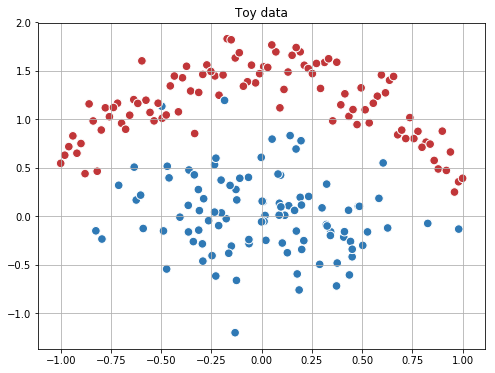

In [292]:
x1 = linspace(-1, 1, 100)
x2 = 1.5 - x1 ** 2 + random.normal(scale=0.2, size=100)
x3 = random.normal(scale=0.4, size=100)
x4 = random.normal(scale=0.4, size=100)

permutation = random.permutation(np.arange(200))
x = hstack((
    vstack((x1, x2)),
    vstack((x3, x4)))).T[permutation]
y = concatenate((
    zeros_like(x1),
    ones_like(x3)))[permutation]

# needed for pictures later
xx, yy = mgrid[-2:2:.01, -2:2:.01]
grid_arr = c_[xx.ravel(), yy.ravel()]

def plot_decision(predicts):
    probas = predicts.reshape(xx.shape)

    contour = contourf(xx, yy, probas, 25, cmap="RdBu", vmin=0, vmax=1)
    colorbar(contour)

    scatter(x[:,0], x[:, 1], c=y, s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)
    title("Some cool decision boundary")
    grid()
    
def plot_optimizers(weights_path1, weights_path2, b=0.):
    w1 = np.arange(1, -10, -0.1)
    w2 = np.arange(-1.2, 1.2, 0.1)
    X, Y = np.meshgrid(w2, w1)

    param_grid = np.dstack((X[..., np.newaxis], Y[..., np.newaxis]))
    grid_dot = np.dot(param_grid, x.T) + b
    grid_sigm = 1 / (1 + np.exp(-grid_dot))
    grid_ce = np.mean(- y * np.log(grid_sigm) - (1 - y) * np.log(1 - grid_sigm), axis=2)

    cnt = contour(X, Y, grid_ce, 20, levels=[ 0.205, 0.21, 0.225, 0.25, 0.3, 0.4, 0.6, 0.8, 1.2, 1.5, 2.])
    clabel(cnt, inline=1, fontsize=10)

    plot(weights_path1[:, 0], weights_path1[:, 1], marker='*', label='Gradient descent')
    plot(weights_path2[:, 0], weights_path2[:, 1], marker='+', label="Newton's method")
    legend(loc='best')
    title("Gradient descent vs Newton's method")
    
scatter(x[:,0], x[:, 1], c=y, s=75,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
title("Toy data")
grid()

### Logistic regression

In [293]:
# allocate parameters
W = theano.shared(
    value=numpy.zeros((2, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b
p_y_given_x = T.nnet.sigmoid(linear)
y_pred = p_y_given_x > 0.5

# define loss-function
loss = T.nnet.binary_crossentropy(p_y_given_x, Y).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    outputs=loss,
    updates=updates,
    allow_input_downcast=True
)

predict_proba = theano.function(
    [X],
    p_y_given_x,
    allow_input_downcast=True
)

In [294]:
sgd_weights = []
for iter_ in range(4001):
    loss = train(x, y[:, np.newaxis])
    sgd_weights.append(W.get_value().flatten())
    if iter_ % 100 == 0:
        print("[Iteration {:04d}] Train loss: {:.4f}".format(iter_, float(loss)))

[Iteration 0000] Train loss: 0.6931
[Iteration 0100] Train loss: 0.4970
[Iteration 0200] Train loss: 0.4053
[Iteration 0300] Train loss: 0.3529
[Iteration 0400] Train loss: 0.3195
[Iteration 0500] Train loss: 0.2966
[Iteration 0600] Train loss: 0.2799
[Iteration 0700] Train loss: 0.2672
[Iteration 0800] Train loss: 0.2573
[Iteration 0900] Train loss: 0.2494
[Iteration 1000] Train loss: 0.2429
[Iteration 1100] Train loss: 0.2375
[Iteration 1200] Train loss: 0.2329
[Iteration 1300] Train loss: 0.2290
[Iteration 1400] Train loss: 0.2256
[Iteration 1500] Train loss: 0.2227
[Iteration 1600] Train loss: 0.2201
[Iteration 1700] Train loss: 0.2179
[Iteration 1800] Train loss: 0.2159
[Iteration 1900] Train loss: 0.2141
[Iteration 2000] Train loss: 0.2125
[Iteration 2100] Train loss: 0.2110
[Iteration 2200] Train loss: 0.2097
[Iteration 2300] Train loss: 0.2085
[Iteration 2400] Train loss: 0.2074
[Iteration 2500] Train loss: 0.2065
[Iteration 2600] Train loss: 0.2056
[Iteration 2700] Train loss:

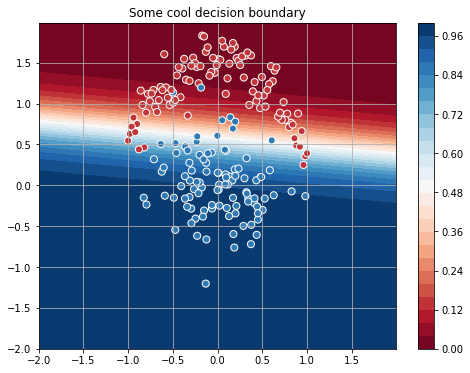

In [295]:
probas = predict_proba(grid_arr)
plot_decision(probas)

In [296]:
# allocate parameters
W_init = numpy.zeros((2,),dtype=theano.config.floatX)
W_flat = theano.shared(W_init, name='W')
W = W_flat.reshape((2, 1))

b_init = numpy.zeros((1,), dtype=theano.config.floatX)
b_flat = theano.shared(b_init, name='b')
b = b_flat.reshape((1,))

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b
p_y_given_x = T.nnet.sigmoid(linear)
y_pred = p_y_given_x > 0.5

# define loss-function
loss = T.nnet.binary_crossentropy(p_y_given_x, Y).mean()

# compute the gradients
g_W = T.grad(loss, W_flat)
g_b = T.grad(loss, b_flat)

h_W = T.nlinalg.matrix_inverse(theano.gradient.hessian(loss, wrt=W_flat))
h_b = T.nlinalg.matrix_inverse(theano.gradient.hessian(loss, wrt=b_flat))

# define parametes updates
updates_newton = [(W_flat, W_flat -  T.dot(h_W , g_W)),
           (b_flat, b_flat - T.dot(h_b, g_b))]

# # compile functions
train_newton = theano.function(
    inputs=[X, Y],
    outputs=loss,
    updates=updates_newton,
    allow_input_downcast=True
)

predict_proba = theano.function(
    [X],
    p_y_given_x,
    allow_input_downcast=True
)

In [297]:
newton_weights = []
for iter_ in range(31):
    loss = train_newton(x, y[:, np.newaxis])
    newton_weights.append(W_flat.get_value())
    if iter_ % 5 == 0:
        print("[Iteration {:04d}] Train loss: {:.4f}".format(iter_, float(loss)))

[Iteration 0000] Train loss: 0.6931
[Iteration 0005] Train loss: 0.2364
[Iteration 0010] Train loss: 0.2014
[Iteration 0015] Train loss: 0.1947
[Iteration 0020] Train loss: 0.1930
[Iteration 0025] Train loss: 0.1926
[Iteration 0030] Train loss: 0.1924


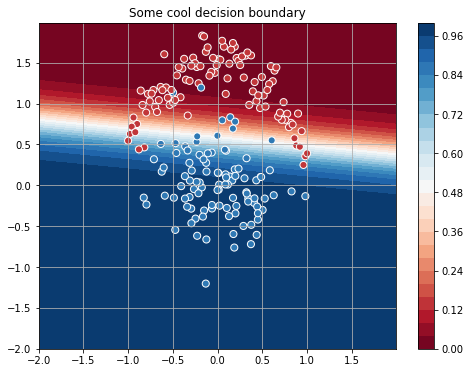

In [298]:
probas = predict_proba(grid_arr)
plot_decision(probas)

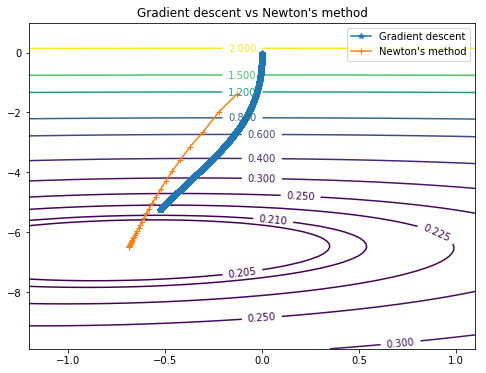

In [301]:
plot_optimizers(np.array(sgd_weights), np.array(newton_weights), b=b_flat.get_value())

### SVM

In [ ]:
# reset parameters
W = theano.shared(
    value=numpy.zeros((2, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)

# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(X, W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    outputs=[loss],
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    [X],
    linear > 0,
    allow_input_downcast=True
)

In [ ]:
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

In [ ]:
preds = predict(grid_arr)
plot_decision(preds)

### "Kernel" trick

In [ ]:
# meet theano's scan:
# allocate variable
i = T.lscalar("i")

# fn parameters: sequences (if any), prior result(s) (if needed), non-sequences (if any)
# the sequences argument is ommited in this example
result, updates = theano.scan(fn=lambda prior_result, i: prior_result * i,
                              # initialize the output
                              outputs_info=T.ones_like(i),
                              # pass input as non sequence
                              non_sequences=i,
                              # this many iterations
                              n_steps=3)

# compile the function
poly = theano.function(inputs=[i], 
                        outputs=result,
                        updates=updates, # actually safe to omit in this case
                        allow_input_downcast=True)
poly(5)

In [ ]:
# meet theano's scan 2:
# allocate variable
I = T.lmatrix("I")

# fn parameters: sequences (if any), prior result(s) (if needed), non-sequences (if any)
# the sequences argument is ommited in this example
result, updates = theano.scan(fn=lambda prior_result, I: prior_result * I,
                              # initialize the output
                              outputs_info=T.ones_like(I),
                              # pass input as non sequence
                              non_sequences=I,
                              # this many iterations
                              n_steps=2)

# x  y  -> x  y  x^2  y^2
# x' y' -> x' y' x'^2 y'^2

output = result.dimshuffle(1, 0, 2).reshape((result.shape[1], 
                                             result.shape[0] * result.shape[2]))
# compile the function
poly = theano.function(inputs=[I], 
                        outputs=output,
                        updates=updates, # actually safe to omit in this case
                        allow_input_downcast=True)
output = poly((arange(6) + 1).reshape(3, 2))
output

More documentation on looping in Theano: http://deeplearning.net/software/theano/library/scan.html

In [ ]:
# reset parameters
def poly(inp, degree=2):
  
    result, updates = theano.scan(fn=lambda prior_result, inp: prior_result * inp,
                                  # initialize the output
                                  outputs_info=T.ones_like(inp),
                                  # pass input as non sequence
                                  non_sequences=inp,
                                  # this many iterations
                                  n_steps=degree)
    return result.dimshuffle(1, 0, 2).reshape((result.shape[1], 
                                               result.shape[0] * result.shape[2]))

# reset parameters
W = theano.shared(
    value=numpy.zeros((8, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)
# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(poly(X, degree=2), W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean()

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    outputs=[loss],
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    [X],
    linear > 0,
    allow_input_downcast=True
)

In [ ]:
batch_size = 4
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

In [ ]:
preds = predict(grid_arr)
plot_decision(preds)

### Regularization

In [ ]:
# reset parameters
W = theano.shared(
    value=zeros((8, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)
# and define symbolic variables
X = T.matrix('X')
Y = T.imatrix('Y')

# define model
linear = T.dot(poly(X, degree=4), W) + b

# We only need to change the loss function
loss = T.maximum(0, 1 - linear * (Y * 2 - 1)).mean() + 1e-3 * T.sum(W ** 2)

# compute the gradients
g_W = T.grad(loss, W)
g_b = T.grad(loss, b)

# define parametes updates
updates = [(W, W - 0.04 * g_W),
           (b, b - 0.08 * g_b)]

# compile functions
train = theano.function(
    inputs=[X, Y],
    outputs=loss,
    updates=updates,
    allow_input_downcast=True
)
               
predict = theano.function(
    inputs=[X],
    linear > 0,
    allow_input_downcast=True
)

In [ ]:
batch_size = 4
for epoch_ in xrange(301):
    loss = []
    # iterate over training samples in minibatches
    for iter_ in xrange(x.shape[0] // batch_size):
        minibatch = slice(iter_ * batch_size, (iter_ + 1) * batch_size)
        loss.append(train(x[minibatch], y[minibatch, np.newaxis]))
    
    e_loss = mean(loss)
    if not epoch_ % 10:
        print("[Epoch %03d] Train loss: %f" % (epoch_, e_loss))

In [ ]:
preds = predict(grid_arr)
plot_decision(preds)

## Lasagne

Lasagne is a lightweight library to build and train neural networks in Theano:

https://github.com/Lasagne/Lasagne

In [ ]:
import lasagne
from lasagne.utils import floatX

import gzip
import time

In [ ]:
!wget -P data http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget -P data  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

In [ ]:
# the following code has been mostly adopted from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py
# you are encouraged to go through the example there or have a look at a more in-depth tutorial: 
# http://lasagne.readthedocs.org/en/latest/user/tutorial.html

def plot_mnist_sample(sample):
    imshow(sample[0], cmap=cm.Greys_r)
    xticks([])
    yticks([])

with gzip.open("data/train-images-idx3-ubyte.gz", 'rb') as f:
    X = frombuffer(f.read(), uint8, offset=16).reshape(-1, 1, 28, 28)
    X = X / floatX(256)
    
with gzip.open("data/train-labels-idx1-ubyte.gz", 'rb') as f:
    y = frombuffer(f.read(), uint8, offset=8)
    
X_train, X_val = X[:-10000], X[-10000:]
y_train, y_val = y[:-10000], y[-10000:]

plot_mnist_sample(X_train[randint(0, 10000)])

### Defining the network

In [ ]:
def build_mlp(input_var=None):
    # This creates an MLP of two hidden layers of 800 units each, followed by
    # a softmax output layer of 10 units. It applies 20% dropout to the input
    # data and 50% dropout to the hidden layers.

    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 28 rows and 28 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    network = lasagne.layers.InputLayer(
        shape=(None, 1, 28, 28),
        input_var=input_var)
    
    # Apply 20% dropout to the input data:
    network = lasagne.layers.DropoutLayer(network, p=0.2)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    network = lasagne.layers.DenseLayer(
        network, 
        num_units=800,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())

    # We'll now add dropout of 50%:
    network = lasagne.layers.DropoutLayer(network, p=0.5)

    # Another 800-unit layer:
    network = lasagne.layers.DenseLayer(
        network,
        num_units=800,
        nonlinearity=lasagne.nonlinearities.rectify)

    # 50% dropout again:
    network = lasagne.layers.DropoutLayer(network, p=0.5)

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    network = lasagne.layers.DenseLayer(
        network,
        num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)

    return network


def build_cnn(input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.
    
    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
        network, 
        num_filters=32,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
        network,
        num_filters=32,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=256,
            nonlinearity=lasagne.nonlinearities.rectify)

    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)

    return network

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = arange(len(inputs))
        random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

### Setting things up

In [ ]:
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

# choose MLP or CNN
network = build_mlp(input_var)
#network = build_cnn(input_var)

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
    loss, 
    params, 
    learning_rate=0.01, 
    momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = T.nnet.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(
    T.eq(T.argmax(test_prediction, axis=1), target_var),
    dtype=theano.config.floatX)

train = theano.function(
    inputs=[input_var, target_var],
    outputs=loss,
    updates=updates)

# Compile a second function computing the validation loss and accuracy:
validate = theano.function(
    inputs=[input_var, target_var],
    outputs=[test_loss, test_acc])


### Training

In [ ]:
print("| Epoch | Train err | Validation err | Accuracy |  Time  |")
print("|--------------------------------------------------------|")

try:
    for epoch in xrange(500):
            # In each epoch, we do a full pass over the training data:
            train_err = 0
            train_batches = 0
            start_time = time.time()
            for batch in iterate_minibatches(X_train, y_train, 500, shuffle=True):
                inputs, targets = batch
                train_err += train(inputs, targets)
                train_batches += 1

            # And a full pass over the validation data:
            val_err = 0
            val_acc = 0
            val_batches = 0
            for batch in iterate_minibatches(X_val, y_val, 500, shuffle=False):
                inputs, targets = batch
                err, acc = validate(inputs, targets)
                val_err += err
                val_acc += acc
                val_batches += 1

            print("|%6d | %9.6f | %14.6f | %8.2f | %6d |" %
                            (epoch,
                             train_err / train_batches,
                             val_err / val_batches,
                             val_acc / val_batches * 100,
                             time.time() - start_time))
except KeyboardInterrupt:
    print("The training was interrupted on epoch: %d." % epoch)

### Goodies

#### Saving your network

In [ ]:
# save the weights
savez('model.npz', *lasagne.layers.get_all_param_values(network))

network = build_mlp()
# And load them again later on like this:
with np.load('model.npz') as f:
     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
lasagne.layers.set_all_param_values(network, param_values)


#### Getting predictions out

In [ ]:
# build the expression
predictions = T.argmax(test_prediction, axis=1)

# define the prediction function
predict = theano.function(
    inputs=[input_var],
    outputs=predictions)

# get just one batch for simplicity
inputs, targets = iterate_minibatches(X_val, y_val, 500, shuffle=False).next()
preds = predict(inputs)
bad_samples = where(preds != targets)[0]


In [ ]:
error = random.choice(bad_samples)
plot_mnist_sample(X_val[error])
print("Predicted: %d True: %d" % (preds[error], targets[error]))

A lot of interesting stuff here: https://github.com/Lasagne/Recipes

# Thank you for your attention!